In [2]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display
from matplotlib.lines import Line2D

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
import numpy as np

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs
import cmocean

import scipy.signal as signal

import sys
sys.path.insert(0, '/net/fs11/d0/emfreese/BC-IRF/')
import utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plots of what the different Green's Functions Look Like by country, time, and linearity tests

In [3]:
regions = ['SEA', 'Indo','Malay','all_countries','Viet','Cambod']
months = ['Jan','Apr','July', 'Oct'] #options are Jan, Apr, July, Oct
time = '2016'
pulse_size = '2x'
length_simulation = 60 #days
diagnostic = 'SpeciesConc'


In [4]:
region_colors = {'all_countries':'navy', 'Indo':'darkslategrey', 'Viet':'darksalmon', 'Malay':'plum', 'Cambod':'olivedrab'}

In [5]:
Indo_colors = {'Indo_Jan_Center':'teal', 'Indo_Jan_NW':'steelblue', 'Indo_Jan_SE':'lightskyblue', 'Indo_Jan':region_colors['Indo']}

In [6]:
Indo_time_colors = {'Indo_Jan_6':'teal', 'Indo_Jan_11':'lightseagreen', 'Indo_Jan_16':'mediumaquamarine', 'Indo_Jan_21':'paleturquoise', 'Indo_Jan':region_colors['Indo']}

## Import the Green's function

In [9]:
G = xr.open_dataset(f'{utils.data_output_path}greens_functions/G_combined.nc', chunks = 'auto')

In [10]:
area_ds = xr.open_dataset(f'{utils.geos_chem_data_path}stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.Emissions.20160101_0000z.nc4')

In [11]:
area_ds = utils.fix_area_ij_latlon(area_ds)


In [14]:
G_mean = G.weighted(area_ds['area']).mean(dim = ['lat','lon'])['BC_total'].isel(lev = 0).compute()

## Indonesia Location Plot

In [ ]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
fig, ax = plt.subplots(figsize = [8,6])
label_dict = {'Indo_Jan':'All Indonesia','Indo_Jan_Center': 'Central Indonesia', 
              'Indo_Jan_NW': 'Northwest Indonesia', 'Indo_Jan_SE':'Southeast Indonesia'}

for r in ['Indo_Jan','Indo_Jan_Center','Indo_Jan_NW','Indo_Jan_SE']:
    if r == 'Indo_Jan':
        plt.plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = r), label = label_dict[r], color = Indo_colors[r], linewidth = 3)
    else:
        plt.plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = r), label = label_dict[r], color = Indo_colors[r], linewidth = 3, linestyle = 'dashed')
plt.xlim(0,30)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title("Pulses Across Indonesia", fontsize = 16)
plt.savefig(f'{utils.figures_data_path}/Linearity_tests/indo_loc_plot.pdf', dpi = 250, bbox_inches = 'tight')

## Indonesia Time Plot

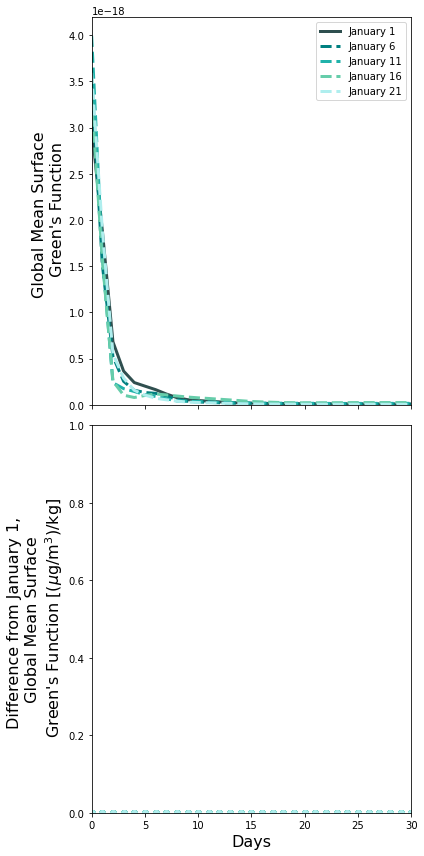

In [16]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
fig, (ax1, ax2) = plt.subplots(2,1,figsize = [6,8], sharex = True)

label_dict = {'Indo_Jan':'January 1','Indo_Jan_6': 'January 6','Indo_Jan_11': 'January 11',
             'Indo_Jan_16': 'January 16', 'Indo_Jan_21': 'January 21'}

for r in ['Indo_Jan','Indo_Jan_6','Indo_Jan_11','Indo_Jan_16','Indo_Jan_21',]:
    if r == 'Indo_Jan':
        ax1.plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = r), label = label_dict[r], color = Indo_time_colors[r], linewidth = 3)
    else:
        ax1.plot(np.arange(0,len(G_mean.sel(run = r)['time'])),G_mean.sel(run = r), label = label_dict[r], color = Indo_time_colors[r], linewidth = 3, linestyle = 'dashed')

plt.xlim(0,30)
plt.ylim(0, None)
ax1.legend()
ax1.set_ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
#plt.title("Pulses At Varying Times in January in Indonesia", fontsize = 16)
#plt.savefig('figures/indo_time_plot.pdf', dpi = 250, bbox_inches = 'tight')
ax1.set_ylim(0,None)

for r in ['Indo_Jan_6','Indo_Jan_11','Indo_Jan_16','Indo_Jan_21',]:
    data = (G_mean.sel(run = r) - G_mean.sel(run = 'Indo_Jan'))#/G_mean.sel(run = 'Indo_Jan')
    ax2.plot(np.arange(0,len(data['time'])),data, color = Indo_time_colors[r], linewidth = 3, linestyle = 'None', marker = 'o')

plt.xlim(0,30)
#plt.legend()
ax2.set_xlabel('Days', fontsize = 16)
ax2.set_ylabel('Difference from January 1, \n Global Mean Surface \n Green\'s Function [($\mu$g/m$^3$)/kg]', fontsize = 16)
#plt.title("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.tight_layout()
plt.savefig('figures/indo_dif_time_plot_both.pdf', dpi = 250, bbox_inches = 'tight')

## All Countries Summed vs. All Countries Pulsed

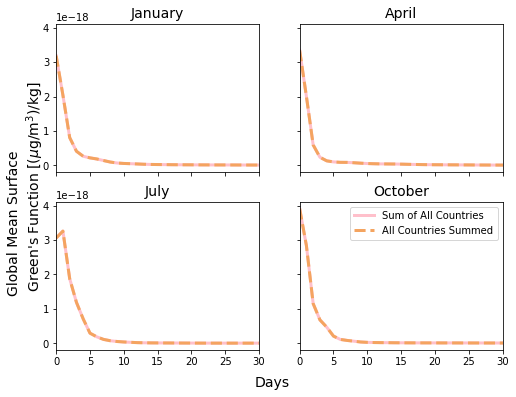

In [40]:
months_dict = {'Jan':'January','Apr':'April','July':'July','Oct':'October'}
fig, axes = plt.subplots(2, 2, sharex = True, sharey = True, figsize = [8,6])
axes = axes.ravel()
for idx, m in enumerate(['Jan','Apr','July','Oct']):
    axes[idx].plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = f'all_countries_summed_{m}'), label = 'Sum of All Countries', color = 'pink', linewidth = 3)
    axes[idx].plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = f'all_countries_{m}'), label = 'All Countries Summed', linestyle = '--', color = 'sandybrown', linewidth = 3)
    axes[idx].set_title(months_dict[m], fontsize = 14)
plt.xlim(0,30)
plt.legend()
fig.text(0.5, 0.04, 'Days', ha='center', fontsize = 14)
fig.text(0.04, 0.5, 'Global Mean Surface \n Green\'s Function [($\mu$g/m$^3$)/kg]', va='center', rotation='vertical', fontsize = 14)
#plt.suptitle("Sum of the Pulse vs. Pulse of the Sum for each Month", fontsize = 16)
plt.savefig('figures/ac_sum_vs_sum_ac.pdf', dpi = 250, bbox_inches = 'tight')

## SEA versus Individual Countries by Season, percent difference

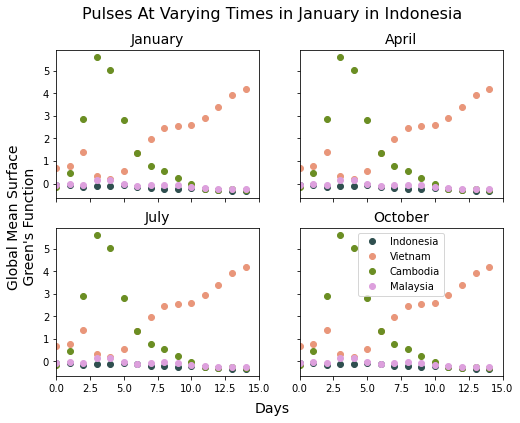

In [36]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
label_dict = {'Indo':'Indonesia', 'Malay':'Malaysia','Viet':'Vietnam','Cambod':'Cambodia', 'SEA':'Southeast Asia'}


fig, axes = plt.subplots(2, 2, sharex = True, sharey = True, figsize = [8,6])
axes = axes.ravel()
for idx, m in enumerate(['Jan','Apr','July','Oct']):
    #axes[idx].plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = f'all_countries_{m}'), label = label_dict['SEA'], color = region_colors['SEA'], linewidth = 3)
    for c in ['Indo','Viet','Cambod','Malay']:
        data = (((G_mean.sel(run = f'{c}_Jan'))-G_mean.sel(run = 'all_countries_Jan'))/G_mean.sel(run = 'all_countries_Jan')).isel(time = slice(0,15))
        axes[idx].plot(np.arange(0,len(data['time'])), data, marker = 'o', label = label_dict[c], color = region_colors[c], linestyle = "None")
        axes[idx].set_title(months_dict[m], fontsize = 14)

plt.legend()
plt.xlim(0,15)
fig.text(0.5, 0.04, 'Days', ha='center', fontsize = 14)
fig.text(0.04, 0.5, 'Global Mean Surface \n Green\'s Function', va='center', rotation='vertical', fontsize = 14)
#plt.suptitle("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.savefig('figures/ac_v_countries_dif.pdf', dpi = 250, bbox_inches = 'tight')

## SEA versus Individual Countries by Season, raw Green's Function

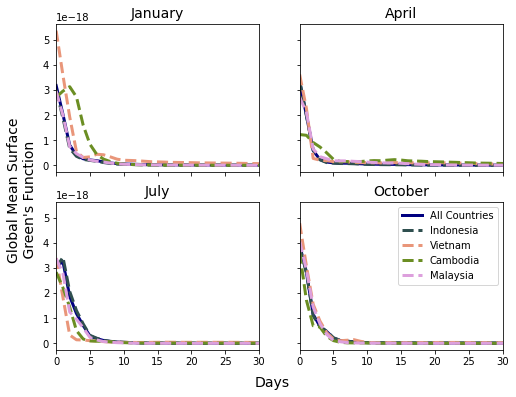

In [15]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
label_dict = {'Indo':'Indonesia', 'Malay':'Malaysia','Viet':'Vietnam','Cambod':'Cambodia', 'all_countries':'All Countries'}
months_dict = {'Jan':'January','Apr':'April','July':'July','Oct':'October'}


fig, axes = plt.subplots(2, 2, sharex = True, sharey = True, figsize = [8,6])
axes = axes.ravel()
for idx, m in enumerate(['Jan','Apr','July','Oct']):
    axes[idx].plot(np.arange(0,len(G_mean.sel(run = f'all_countries_{m}')['time'])), G_mean.sel(run = f'all_countries_{m}'), label = label_dict['all_countries'], color = region_colors['all_countries'], linewidth = 3)
    for c in ['Indo','Viet','Cambod','Malay']:
        axes[idx].plot(np.arange(0,len(G_mean.sel(run = f'{c}_{m}')['time'])), G_mean.sel(run = f'{c}_{m}'), label = label_dict[c], color = region_colors[c], linewidth = 3, linestyle = '--')
        axes[idx].set_title(months_dict[m], fontsize = 14)

plt.legend()
plt.xlim(0,30)
fig.text(0.5, 0.04, 'Days', ha='center', fontsize = 14)
fig.text(0.04, 0.5, 'Global Mean Surface \n Green\'s Function', va='center', rotation='vertical', fontsize = 14)
#plt.suptitle("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.savefig('figures/SEA_v_countries.pdf', dpi = 250, bbox_inches = 'tight')

## Combined linearity test

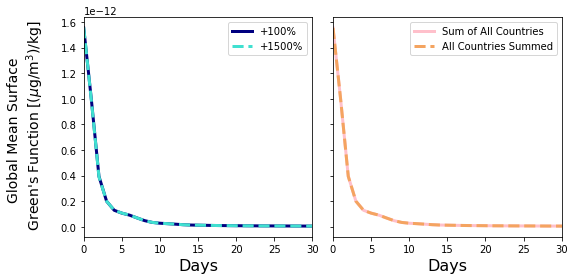

In [10]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
label_dict = {'all_countries_Jan_16x':r'+1500%','all_countries_Jan': r'+100%'}
times_colors = {'all_countries_Jan_16x': 'turquoise','all_countries_Jan':'navy'}
months_dict = {'Jan':'January','Apr':'April','July':'July','Oct':'October'}
fig, (ax1, ax2) = plt.subplots(1,2,figsize = [8,4], sharey = True)

#16x v 2x
ax1.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_Jan')['time'])), G_mean.sel(run = 'all_countries_Jan'), label = label_dict['all_countries_Jan'], 
         color = times_colors['all_countries_Jan'], linewidth = 3)
ax1.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_Jan_16x')['time'])), G_mean.sel(run = 'all_countries_Jan_16x'), label = label_dict['all_countries_Jan_16x'], 
         color = times_colors['all_countries_Jan_16x'], linestyle = '--', linewidth = 3)

    
ax1.legend()
ax1.set_xlim(0,30)
ax1.set_xlabel('Days', fontsize = 16)
ax1.set_ylabel('Global Mean Surface \n Green\'s Function [($\mu$g/m$^3$)/kg]', va='center', rotation='vertical', labelpad = -.3, fontsize = 14)
ax1.yaxis.set_label_coords(-0.25, 0.5)

#all countries summed
ax2.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_summed_Jan')['time'])), G_mean.sel(run = f'all_countries_summed_Jan'), label = 'Sum of All Countries', color = 'pink', linewidth = 3)
ax2.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_Jan')['time'])), G_mean.sel(run = f'all_countries_Jan'), label = 'All Countries Summed', linestyle = '--', color = 'sandybrown', linewidth = 3)


ax2.set_xlim(0,30)
ax2.legend()
ax2.set_xlabel('Days', fontsize = 16)
plt.tight_layout()
#plt.suptitle("Sum of the Pulse vs. Pulse of the Sum for each Month", fontsize = 16)
plt.savefig('figures/linearity_tests.pdf', dpi = 250, bbox_inches = 'tight')


## 16x vs. 2x

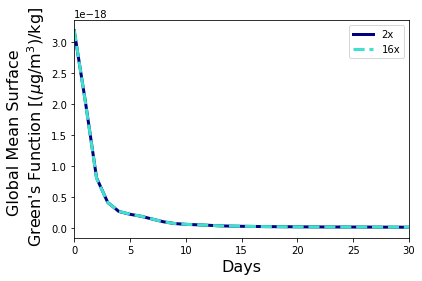

In [39]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
label_dict = {'all_countries_Jan_16x':'16x','all_countries_Jan': '2x'}
times_colors = {'all_countries_Jan_16x': 'turquoise','all_countries_Jan':'navy'}
plt.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_Jan')['time'])), G_mean.sel(run = 'all_countries_Jan'), label = label_dict['all_countries_Jan'], 
         color = times_colors['all_countries_Jan'], linewidth = 3)
plt.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_Jan_16x')['time'])), G_mean.sel(run = 'all_countries_Jan_16x'), label = label_dict['all_countries_Jan_16x'], 
         color = times_colors['all_countries_Jan_16x'], linestyle = '--', linewidth = 3)

    
plt.legend()
plt.xlim(0,30)
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function [($\mu$g/m$^3$)/kg]', fontsize = 16)
#plt.title("16x and 2x pulses in All Countries, January", fontsize = 16)
plt.savefig('figures/16x_2x_jan_plot.pdf', dpi = 250, bbox_inches = 'tight')

## Map of 16x vs 2x

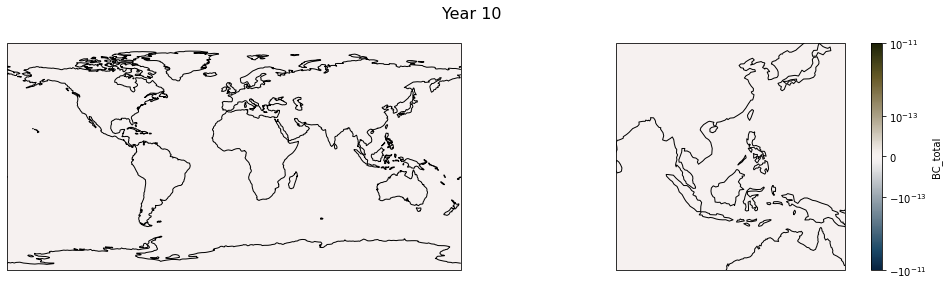

In [13]:
t = 10
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
data = (G.sel(run = 'all_countries_Jan_16x').isel(time = t, lev = 0) - 
  G.sel(run = 'all_countries_Jan').isel(time = t, lev = 0))['BC_total']
##### global view #######
(data).plot(ax = ax1, transform = ccrs.PlateCarree(),norm = SymLogNorm(1e-13, 1, -1e-11, 1e-11), 
            add_colorbar = False, cmap = cmocean.cm.diff)
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(data).plot(ax = ax2, transform = ccrs.PlateCarree(), 
            norm = SymLogNorm(1e-13, 1, -1e-11, 1e-11), cmap = cmocean.cm.diff)
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Year {t}', fontsize = 16);
plt.tight_layout()
plt.savefig(f"figures/16x_2x_map.png", dpi = 350, bbox_inches = 'tight')

## Mean Across Months vs. Individual Months by Country

In [16]:
for c in ['Indo','Viet','Cambod','Malay']:
    print(G_mean.loc[G_mean.run.isin([f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run').isel(time = slice(1,15)).diff(dim = 'time').values)

[-6.89512120e-13 -2.31903911e-13 -1.13807541e-13 -9.43595794e-14
 -3.24972509e-14 -1.98966118e-14 -1.40883825e-14 -9.63599020e-15
 -5.44585760e-15 -3.38382765e-15 -3.05448378e-15 -2.15977175e-15
 -1.50746446e-15]
[-8.41765579e-13 -2.87207411e-13 -8.87312655e-14 -3.57375807e-14
  3.16697898e-15 -2.97380579e-15 -1.22801142e-14 -2.36017925e-14
 -1.12640010e-14 -3.67806064e-15 -1.90283844e-15 -1.27518218e-15
 -2.02276511e-15]
[-2.30176069e-13 -1.91394723e-13 -2.49254340e-13 -1.54285306e-13
 -6.85417761e-14 -2.61506752e-14 -1.55866438e-14 -9.51429684e-15
 -3.39091314e-15 -1.75951921e-15 -2.52236539e-15  2.07878361e-15
  1.59032895e-15]
[-6.95832905e-13 -1.87083688e-13 -1.22986026e-13 -9.70778608e-14
 -2.43028206e-14 -1.60906596e-14 -1.19068883e-14 -7.73675446e-15
 -5.51160143e-15 -3.93038988e-15 -3.53078654e-15 -1.87363365e-15
 -9.31476764e-16]


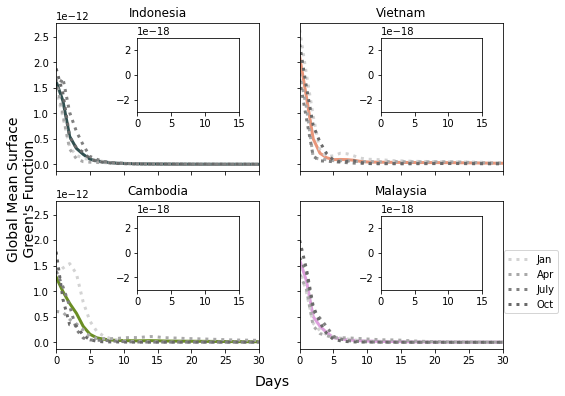

In [14]:
label_dict = {'Indo':'Indonesia', 'Malay':'Malaysia','Viet':'Vietnam','Cambod':'Cambodia'}



fig, axes = plt.subplots(2, 2, sharex = True, sharey = True, figsize = [8,6])
axes = axes.ravel()
for idx, c in enumerate(['Indo','Viet','Cambod','Malay']):
    axes[idx].plot(np.arange(0,len(G_mean.sel(run = f'{c}_Jan')['time'])), G_mean.loc[G_mean.run.isin([f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run'), 
                   color = region_colors[c], linewidth = 3)
    colors = iter(['lightgrey','darkgrey', 'grey','dimgrey'])
    ##inset
    axins = axes[idx].inset_axes([.4,.4,.5,.5])
    for m in ['Jan','Apr','July','Oct']:
        col = next(colors)
        axes[idx].plot(np.arange(0,len(G_mean.sel(run = f'{c}_{m}')['time'])), G_mean.sel(run = f'{c}_{m}'), label = m, linestyle = ':', color = col, linewidth = 3)
        ##inset for the difference from the mean
        data = (G_mean.sel(run = f'{c}_{m}') - G_mean.loc[G_mean.run.isin([f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run'))#/G_mean.loc[G_mean.run.isin([f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run')
        axins.plot(np.arange(0,len(data['time'])), data, color = col, linestyle = 'None', marker = '.')
        axins.set_xlim(0,15)
        axins.set_ylim(-3e-18,3e-18)
        
    axes[idx].set_title(label_dict[c])
    
custom_lines = [Line2D([0], [0], color='black', lw=3)]
axes[3].legend(custom_lines, ['Mean Across Months'])

plt.legend(bbox_to_anchor = (1.1, .5, .2, .2))
plt.xlim(0,30)
fig.text(0.5, 0.04, 'Days', ha='center', fontsize = 14)
fig.text(0.04, 0.5, 'Global Mean Surface \n Green\'s Function', va='center', rotation='vertical', fontsize = 14)
#plt.suptitle("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.savefig('figures/monthly_mean_v_months_country.pdf', dpi = 250, bbox_inches = 'tight')

## China specific

In [34]:
country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
country_impacted = 'China'


In [35]:
mask = country_mask.mask(G, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
country_impacted_ds = G.where(contiguous_mask)

In [12]:
mean_country_impact = country_impacted_ds.weighted(area_ds['area']).mean(dim = ['lat','lon']).isel(lev = 0)

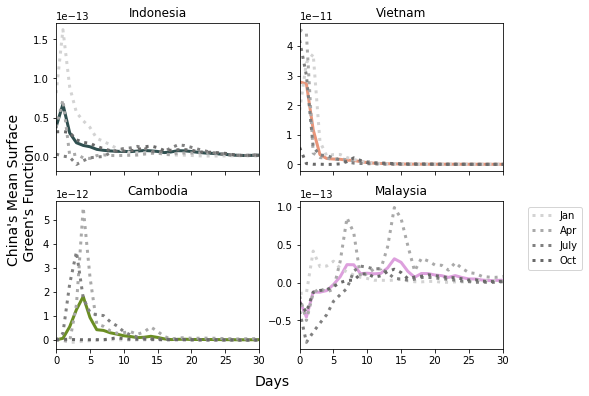

In [64]:
label_dict = {'Indo':'Indonesia', 'Malay':'Malaysia','Viet':'Vietnam','Cambod':'Cambodia'}



fig, axes = plt.subplots(2, 2, sharex = True, figsize = [8,6])
axes = axes.ravel()
for idx, c in enumerate(['Indo','Viet','Cambod','Malay']):
    axes[idx].plot(np.arange(0,len(mean_country_impact.sel(run = f'{c}_Jan')['time'])), mean_country_impact.loc[dict(run = [f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run')['BC_total'], 
                   color = region_colors[c], linewidth = 3)
    colors = iter(['lightgrey','darkgrey', 'grey','dimgrey'])
    #inset
    #axins = axes[idx].inset_axes([.4,.4,.5,.5])
    for m in ['Jan','Apr','July','Oct']:
        col = next(colors)
        axes[idx].plot(np.arange(0,len(mean_country_impact.sel(run = f'{c}_{m}')['time'])), mean_country_impact.sel(run = f'{c}_{m}')['BC_total'], label = m, linestyle = ':', color = col, linewidth = 3)
        axes[idx].set_title(label_dict[c])
#         ##inset for the difference from the mean
#         data = (mean_country_impact.sel(run = f'{c}_{m}')['BC_total'] - mean_country_impact.loc[dict(run = [f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run')['BC_total'])#/mean_country_impact.loc[mean_country_impact.run.isin([f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run')
#         axins.plot(np.arange(0,len(data['time'])), data, color = col, linestyle = 'None', marker = '.')
#         axins.set_xlim(0,15)
#         axins.set_ylim(-3e-18,3e-18)
        
         
    
custom_lines = [Line2D([0], [0], color='black', lw=3)]
axes[3].legend(custom_lines, ['Mean Across Months'])

plt.legend(bbox_to_anchor = (1.1, .5, .2, .2))
plt.xlim(0,30)
fig.text(0.5, 0.04, 'Days', ha='center', fontsize = 14)
fig.text(0.04, 0.5, 'China\'s Mean Surface \n Green\'s Function', va='center', rotation='vertical', fontsize = 14)
#plt.suptitle("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.savefig('figures/china_monthly_mean_v_months_country.pdf', dpi = 250, bbox_inches = 'tight')